# Baseline examples

Charles Le Losq

August 2016

This notebook shows examples of how to use the baseline function, and compares the outcomes of using splines over machine learning algorithms.
    
First we call the relevant libraries.

In [1]:
using Spectra
using PyPlot

INFO: Recompiling stale cache file /Users/charles/.julia/lib/v0.4/Spectra.ji for module Spectra.


Now we import one of the Raman spectrum from the example data folder, and we plot it to have a nice look at it.

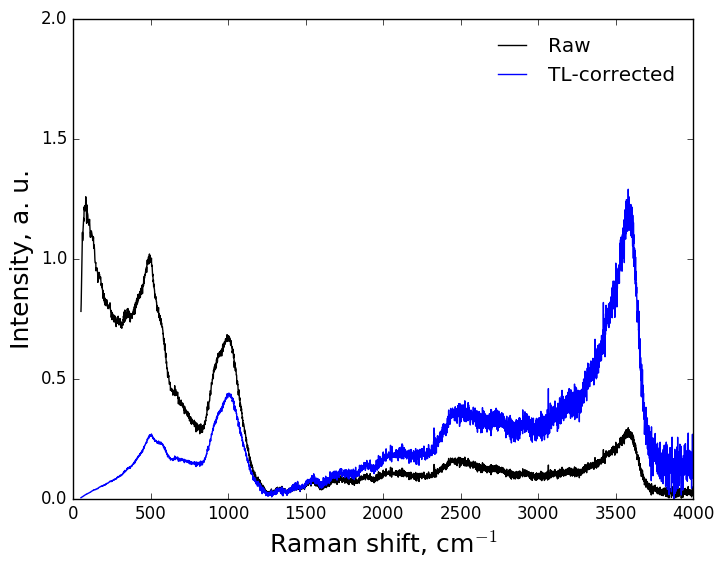

PyObject <matplotlib.text.Text object at 0x31f295790>

In [2]:
# We import the spectrum
spectra = readdlm("./data/r040.txt")

# We check that the x values (Raman shifts) are increasing, if not we flip the array
if spectra[end,1] < spectra[1,1]
    spectra = flipdim(spectra,1)
end

# Before the temperature-excitation line correction, we remove the minimum value fo the spectrum. This limits the distortion of the spectrum:
spectra[:,2] = spectra[:,2]-minimum(spectra[:,2])

# We perform the temperature-excitation line correction
x, y_long,ese_long = tlcorrection(spectra,23.0,532.0);

y = spectra[:,2] # this one will record the raw signal. We will use it later.

# Now a plot of the entire spectrum, raw and corrected from temperature and excitation line effect.
# We need to normalise the original spectrum as the tlcorrection applies automatically a normalisation of the signal to
# the area beyond it. We will use the trapz function (see Spectra documentation)
scaling_factor = 1000.
figure() # we create the figure

# Here are the functions to plot the lines
plot(x,y./trapz(x,y).*scaling_factor,color="black",label="Raw")
plot(x,y_long.*scaling_factor,color="blue",label="TL-corrected")

# we set the limits fo the axis
xlim(0,4000)
ylim(0.,2.0)

# we display the legend at the best location, without a frame
legend(loc="best",frameon=false)

# we set the values of the labels of the x and y axis.
xlabel(L"Raman shift, cm$^{-1}$",fontsize=18) # The L in front of the string indicates that we use Latex
ylabel("Intensity, a. u.",fontsize=18)

# Subtracting baseline from Raman spectra after temperature and excitation line effect corrections


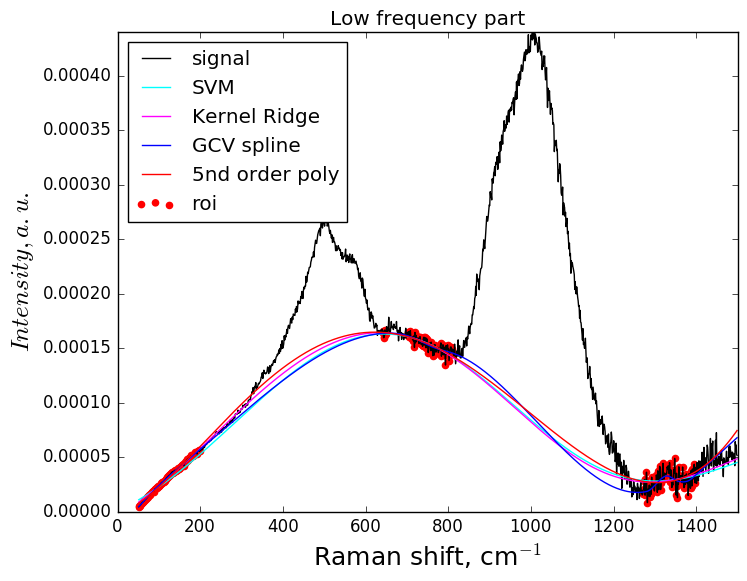

PyObject <matplotlib.text.Text object at 0x3222b6050>

In [3]:
# We define the portions of the spectra where we want to fit the signal background.
# They are called regions of interest (roi) or background interpolation regions (bir) in Spectra.jl.
roi = [0. 200.; 640. 650.; 700. 810.; 1270. 1400.; 2500. 3000.; 3800. 4000.]


# There we restrain the fit of the background to a specific low or high frequency wavelength. 
# This will affect the smoothing coefficient for th gcvspline for instance, or how behaves the 
# machine learning algorithms.
x_fit=x[x.<1500]
y_fit=y_long[x.<1500]
#y_fit = y_fit./maximum(y_fit) + 0.1

y_svm, bas_svm = baseline(x_fit,y_fit,roi,"SVMregression")
y_kr, bas_kr = baseline(x_fit,y_fit,roi,"KRregression")
y_gcvspline, bas_gcvspline = baseline(x_fit,y_fit,roi,"gcvspline",p=0.01)
# We also try the polynomial function, with an explicit output of the x and y values used to fit the signal in the 
# xy_roi array. We will use it in the plots.
y_poly, bas_poly, xy_roi = baseline(x_fit,y_fit,roi,"poly",p=5.0,roi_out="yes")

figure()
title("Low frequency part")
plot(x_fit,y_fit,"black",label="signal")
scatter(xy_roi[:,1],xy_roi[:,2],color="red",label="roi") # the signal used to fit the baselines

plot(x_fit,bas_svm,"cyan",label="SVM")
plot(x_fit,bas_kr,"magenta",label="Kernel Ridge")
plot(x_fit,bas_gcvspline,"blue",label="GCV spline")
plot(x_fit,bas_poly,"red",label="5nd order poly")
xlim(0,1500)
ylim(0,maximum(y_fit[x_fit.<1500]))
legend(loc="best")
xlabel(L"Raman shift, cm$^{-1}$",fontsize=18)
ylabel(L"Intensity, a. u.",fontsize=18)

In [ ]:
x_fit=x[x.>2500.]
y_fit=y_long[x.>2500.]
#y_fit[y_fit.==0.0] = 0.0001

y_svm, bas_svm = baseline(x_fit,y_fit,roi,"SVMregression")
y_kr, bas_kr = baseline(x_fit,y_fit,roi,"KRregression")
y_gcvspline, bas_gcvspline, xy_out = baseline(x_fit,y_fit,roi,"gcvspline",p=0.012,roi_out="yes")
y_poly, bas_poly = baseline(x_fit,y_fit,roi,"poly",p=5.0)

figure()
title("High frequency part")
plot(x_fit,y_fit,"black",label="signal")
scatter(xy_out[:,1],xy_out[:,2],color="red",label="roi")
#plot(x_fit,bas_svm,"cyan",label="SVM")
#plot(x_fit,bas_kr,"magenta",label="Kernel Ridge")
plot(x_fit,bas_gcvspline,"blue",label="GCV spline")
#plot(x_fit,bas_poly,"red",label="5nd order poly")
xlim(2500,4000)
ylim(0,maximum(y_fit[x_fit.>2500]))
legend(loc="best")
xlabel(L"Raman shift, cm$^{-1}$",fontsize=18)
ylabel(L"Intensity, a. u.",fontsize=18)

# .. and on RAW spectrum:

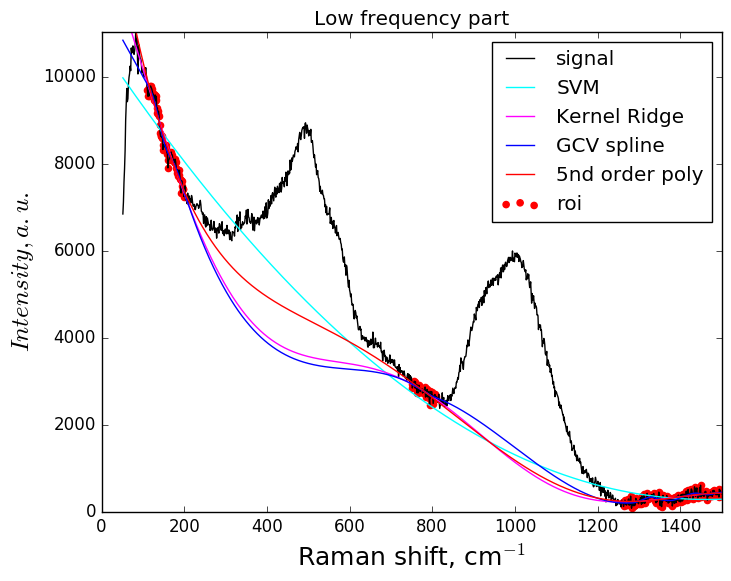

/Users/charles/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/charles/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/charles/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if

PyObject <matplotlib.text.Text object at 0x32505ee10>

In [14]:
x_fit=x[x.<1500]
y_fit=y[x.<1500]
# and we need to change the roi because of the Boson peak
roi = [110. 200.; 750. 810.; 1260. 2000;2100 3000; 3800 4000]

y_svm, bas_svm = baseline(x_fit,y_fit,roi,"SVMregression") # the support vector regression
y_kr, bas_kr = baseline(x_fit,y_fit,roi,"KRregression") # the kernel ridge regression
y_gcvspline, bas_gcvspline = baseline(x_fit,y_fit,roi,"gcvspline",p=0.35) # using the GCV spline, with the smoothing factor
y_poly, bas_poly, xy_roi = baseline(x_fit,y_fit,roi,"poly",p=5.0,roi_out="yes")

# There we do the plots.
figure()
title("Low frequency part")
plot(x_fit,y_fit,"black",label="signal") # the signal
scatter(xy_roi[:,1],xy_roi[:,2],color="red",label="roi") # the signal used to fit the baselines

# And below the code to fit the different baselines
plot(x_fit,bas_svm,"cyan",label="SVM")
plot(x_fit,bas_kr,"magenta",label="Kernel Ridge")
plot(x_fit,bas_gcvspline,"blue",label="GCV spline")
plot(x_fit,bas_poly,"red",label="5nd order poly")

# Some plotting options
xlim(0,1500)
ylim(0,maximum(y_fit[x_fit.<1500]))
legend(loc="best")
xlabel(L"Raman shift, cm$^{-1}$",fontsize=18)
ylabel(L"Intensity, a. u.",fontsize=18)

In [12]:
# There for the example we are going to use the Dierckx spline, instead of the gcvspline
x_fit=x[x.>2000.]
y_fit=y[x.>2000.]

#y_svm, bas_svm = baseline(x_fit,y_fit,roi,"SVMregression") # the support vector regression
#y_kr, bas_kr = baseline(x_fit,y_fit,roi,"KRregression") # the kernel ridge regression
y_gcvspline, bas_gcvspline = baseline(x_fit,y_fit,roi,"Dspline",p=0.001) # using the GCV spline, with the smoothing factor
y_poly, bas_poly, xy_roi = baseline(x_fit,y_fit,roi,"poly",p=5.0,roi_out="yes") # a simple 5th order polynomial, with output of the roi

# There we do the plots.
figure()
title("High frequency part")
plot(x_fit,y_fit,"black",label="signal") # the signal
scatter(xy_roi[:,1],xy_roi[:,2],color="red",label="roi") # the signal used to fit the baselines

# And below the code to fit the different baselines
#plot(x_fit,bas_svm,"cyan",label="SVM")
#plot(x_fit,bas_kr,"magenta",label="Kernel Ridge")
plot(x_fit,bas_gcvspline,"blue",label="GCV spline")
plot(x_fit,bas_poly,"red",label="5nd order poly")

# Some plotting options
xlim(2500,4000)
ylim(0,maximum(y_fit[x_fit.>2500]))
legend(loc="best")
xlabel(L"Raman shift, cm$^{-1}$",fontsize=18)
ylabel(L"Intensity, a. u.",fontsize=18)

/Users/charles/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


LoadError: LoadError: MethodError: `call` has no method matching call(::Type{Dierckx.Spline1D}, ::Array{Float64,2}, ::Array{Float64,2})
Closest candidates are:
  BoundsError(!Matched::Any...)
  TypeVar(!Matched::Any...)
  TypeConstructor(!Matched::Any...)
  ...
while loading In[12], in expression starting on line 7